Name:Deepak K<br>
Email:deepakjeff2@gmail.com

#### https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

Download dataset from above link, you will predict if given sentence is bullying


# Classification Assignment (End-to-End)

In [22]:
#import libraries

import string
import nltk
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from contractions import contractions_dict
from autocorrect import Speller #correcting the spellings

#libraries for general purposes
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Data Preprocessing
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import warnings
warnings.filterwarnings('ignore')

In [23]:
#importing dataset
df = pd.read_csv("cyberbullying.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [24]:
df.shape

(47692, 2)

In [25]:
#Data understanding
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [26]:
#dropping other_cyberbullying column because model will be confused with other columns
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

In [27]:
#Data Cleaning if required
df.duplicated().sum()

36

In [28]:
#renaming column for clarity
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [29]:
#encoding sentiment column
df["sentiment"].replace({"religion": 1, "age": 2, "gender": 3, "ethnicity": 4, 'not_cyberbullying':5}, inplace=True)
df['sentiment'].value_counts()

1    7998
2    7992
3    7973
4    7961
5    7945
Name: sentiment, dtype: int64

In [30]:
sentiments = ["religion","age","gender","ethnicity","not bullying"]

In [31]:
#creating functions for cleaning the text
stop_words = set(stopwords.words('english'))

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def preprocess(text):
    #text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [32]:
#cleaning the text
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))

In [33]:
df['text_clean'] = texts_cleaned

In [34]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...


In [35]:
#checking for duplicates
df["text_clean"].duplicated().sum()

1049

In [36]:
#dropping duplicates
df.drop_duplicates("text_clean", inplace=True)

In [37]:
df.sentiment.value_counts()

1    7946
2    7884
4    7746
5    7637
3    7607
Name: sentiment, dtype: int64

### EDA

In [38]:
#creating column for text length
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [39]:
df['text_len'] = text_len

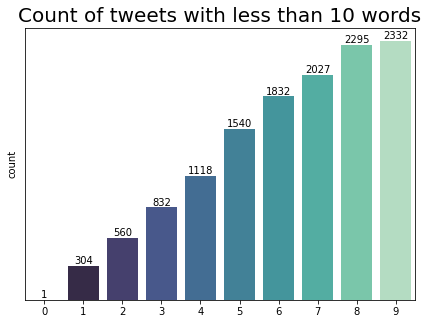

In [40]:
#plotting the text length
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [41]:
# checking long tweets
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,4,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",4,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",2,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,5,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,4,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
1607,@harmlesstree2 Here7 https://t.co/xWJzpSodGj,5,here7,1
6696,@LiamTighe Rebecca who?,5,rebecca,1
558,@root_tim this is my work :),5,work,1
3462,@jaredchase killing you how?,5,kill,1


In [42]:
#dropping the outliers
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [43]:
df

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",4,black ppl expect anyth depend anyth yet free p...,21
47688,Turner did not withhold his disappointment. Tu...,4,turner withhold turner call court abomin concl...,28
47689,I swear to God. This dumb nigger bitch. I have...,4,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,4,yea fuck rt your nigger fuck unfollow fuck dum...,10


# Feature Engineering

In [49]:
# BOW and TF-IDF representation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
clf = CountVectorizer()

x_cv = clf.fit_transform(df['text_clean'])

tf_transform = TfidfTransformer(use_idf=True).fit(x_cv)
x_tf = tf_transform.transform(x_cv)

In [50]:
#Data splitting
x_train,x_test,y_train,y_test = train_test_split(x_tf,df['sentiment'],test_size=0.2,stratify=df['sentiment'],random_state=42)

# Model building

In [ ]:
'''
naive bayes classifier
SVC classifier
Decision Tree Classifier
Random forest classifier
'''

In [66]:
#importing models and initializing models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

nb = MultinomialNB()
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [67]:
#fitting the training data to the models
nb.fit(x_train,y_train)
svc.fit(x_train,y_train)
dt.fit(x_train,y_train)
rf.fit(x_train,y_train)

RandomForestClassifier()

# Metrics

In [73]:
#create a Data Frame showing metrics of above models
from sklearn.metrics import accuracy_score
from sklearn.metrics i
mport recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#create a function which takes model as input and will return a list with following scores
def models_metrics(model):
    lis = []
    lis.append(accuracy_score(y_test,model.predict(x_test)))
    lis.append(recall_score(y_test,model.predict(x_test),pos_label=1,average='macro'))
    lis.append(recall_score(y_test,model.predict(x_test),pos_label=0,average='macro'))
    lis.append(precision_score(y_test,model.predict(x_test),pos_label=1,average='macro'))
    lis.append(precision_score(y_test,model.predict(x_test),pos_label=0,average='macro'))
    lis.append(f1_score(y_test,model.predict(x_test),pos_label=1,average='macro'))
    lis.append(f1_score(y_test,model.predict(x_test),pos_label=0,average='macro'))
    

    return lis

#create a dataframe with models and their scores
Metrics_df = pd.DataFrame()
models = []
Metrics_df["Metrics"] = ['accuracy_score','recall sensitivity','recall specificity','Precision positive','Precision negative','f1_score positive','f1_score negative']
Metrics_df['Naives Bayes'] = models_metrics(nb)
Metrics_df['SVC'] = models_metrics(svc)
Metrics_df['Decision Tree'] = models_metrics(dt)
Metrics_df['Random Forest'] = models_metrics(rf)

Metrics_df

,Metrics,Naives Bayes,SVC,Decision Tree,Random Forest
0,accuracy_score,0.834838,0.929543,0.917958,0.940590
1,recall sensitivity,0.817689,0.926855,0.913237,0.937723
2,recall specificity,0.817689,0.926855,0.913237,0.937723
3,Precision positive,0.843393,0.928516,0.913163,0.938180
4,Precision negative,0.843393,0.928516,0.913163,0.938180
5,f1_score positive,0.806956,0.926483,0.913148,0.937206
6,f1_score negative,0.806956,0.926483,0.913148,0.937206


### explain which model does it better 
* Random Forest gives the best accuaracy

# GridSearch CV

In [76]:
# implement grid search for the best model, recommend best hyperparameters
model_params = {
    'naive_bayes_gaussian': {
            'model': MultinomialNB(),
        'params': {}
    },
    'svm': {
        'model': SVC(gamma='auto'),
        'params' : {
            'C': [10,20],
            'kernel': ['rbf','linear']
        }  
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5]
        }
    }   
}

In [77]:
from sklearn.model_selection import GridSearchCV
scores = []
for model_name,mp in model_params.items():
    clf = GridSearchCV(mp['model'],mp['params'],cv=5,return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model':model_name,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })

In [78]:
scores_df = pd.DataFrame(scores)
scores_df

,model,best_score,best_params
0,naive_bayes_gaussian,0.835135,{}
1,svm,0.908996,"{'C': 10, 'kernel': 'linear'}"
2,decision_tree,0.917483,{'criterion': 'entropy'}
3,random_forest,0.895827,{'n_estimators': 5}
